In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import clean data

In [20]:
df = pd.read_csv("WPP2022.csv",low_memory=False)

In [21]:
# add GDP to my data
df_gdp = pd.read_csv("world_country_gdp_usd.csv",header=0)
df_gdp.dropna(inplace=True)
dfm = df.merge(df_gdp,on =["Country Name","year"])
dfm =dfm.replace('...', np.nan) 


In [22]:
# import missingno as msno
# msno.matrix(dfm)

In [23]:
df = dfm.iloc[:, 10:]
df =df.drop(["Country Code"],axis=1)
df =df.drop(["GDP_USD"],axis=1)
df = df.apply(pd.to_numeric)
df["Country Name"] = dfm["Country Name"]
df["year"]= dfm["year"]
df= df.dropna()
df.reset_index(inplace=True,drop=True)

In [24]:
df_name= df.loc[:,["Country Name","year"]]
df = df.drop(["Country Name","year"],axis=1)

## Feature Selection
Target leakage is a common issue in feature selection for regression, where information from the target variable is inadvertently incorporated into the selected features.
This can lead to a model that appears to perform well on the training data but performs poorly on new, unseen data.
To avoid target leakage, we use the feature selection
* at first remove correlated features
compare the correlation between features and remove one of two features that have a absolute correlation higher than 0.7

In [25]:
target = "Life Expectancy at Birth, both sexes (years)"
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.7 :
            if  target in [corr.columns[j],corr.columns[i]]:
                if corr.columns[j] == target :
                    columns[i] = False
                else:
                    columns[j] = False
            else:
                columns[j] = False
            

selected_columns = df.columns[columns]
df = df[selected_columns]
print(f"{sum(columns)} number of columns selected")

9 number of columns selected


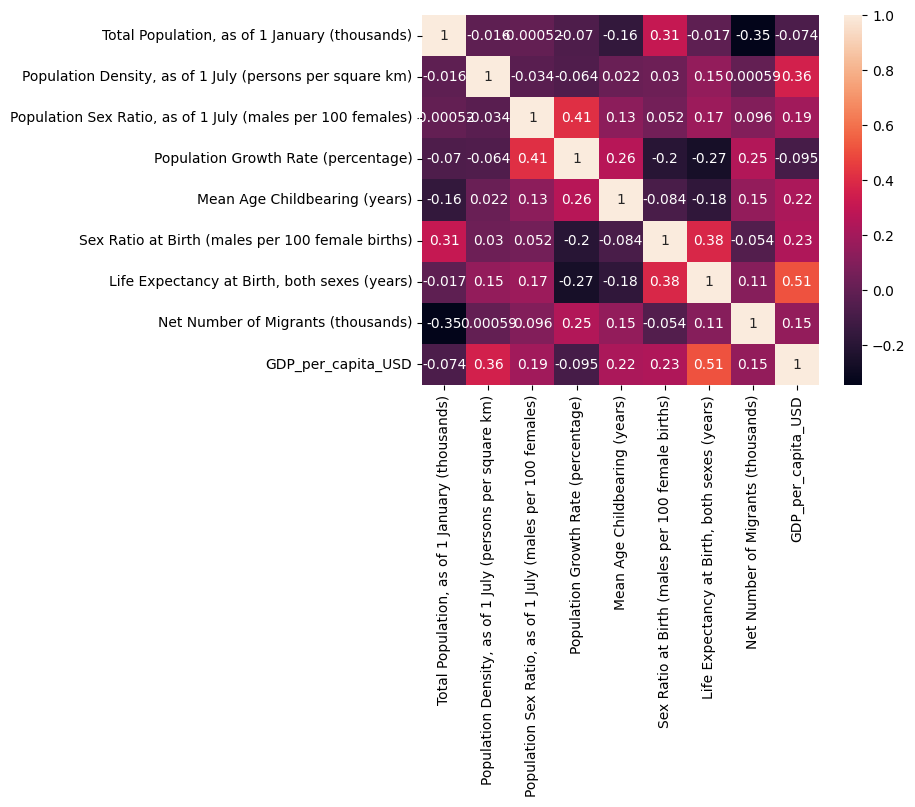

In [26]:
# heatmap correlation matrix
#fig, ax = plt.subplots(figsize=(50,50)) 
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.savefig("gg.png")

## Selecting columns based on p-value
* We assume to null hypothesis to be “The selected combination of dependent variables do not have any effect on the independent variable”.
* Then we build a small regression model and calculate the p values.
* If the p values is higher than the threshold, we discard that combination of features.

In [27]:
y= df[target]
df.drop(target, axis=1,inplace=True)

In [28]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns



In [29]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(df.iloc[:,:].values ,y.values, SL, df.columns)
result = pd.DataFrame()
result['diagnosis'] = y
df_select = pd.DataFrame(data = data_modeled, columns = selected_columns)
df_select[target]= y

In [30]:
print(f"{len(df_select.columns)-1} number of columns selected")

8 number of columns selected


## Scaling features 

In [31]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_select)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_select.columns)


## Visualizing the selected and scaled features

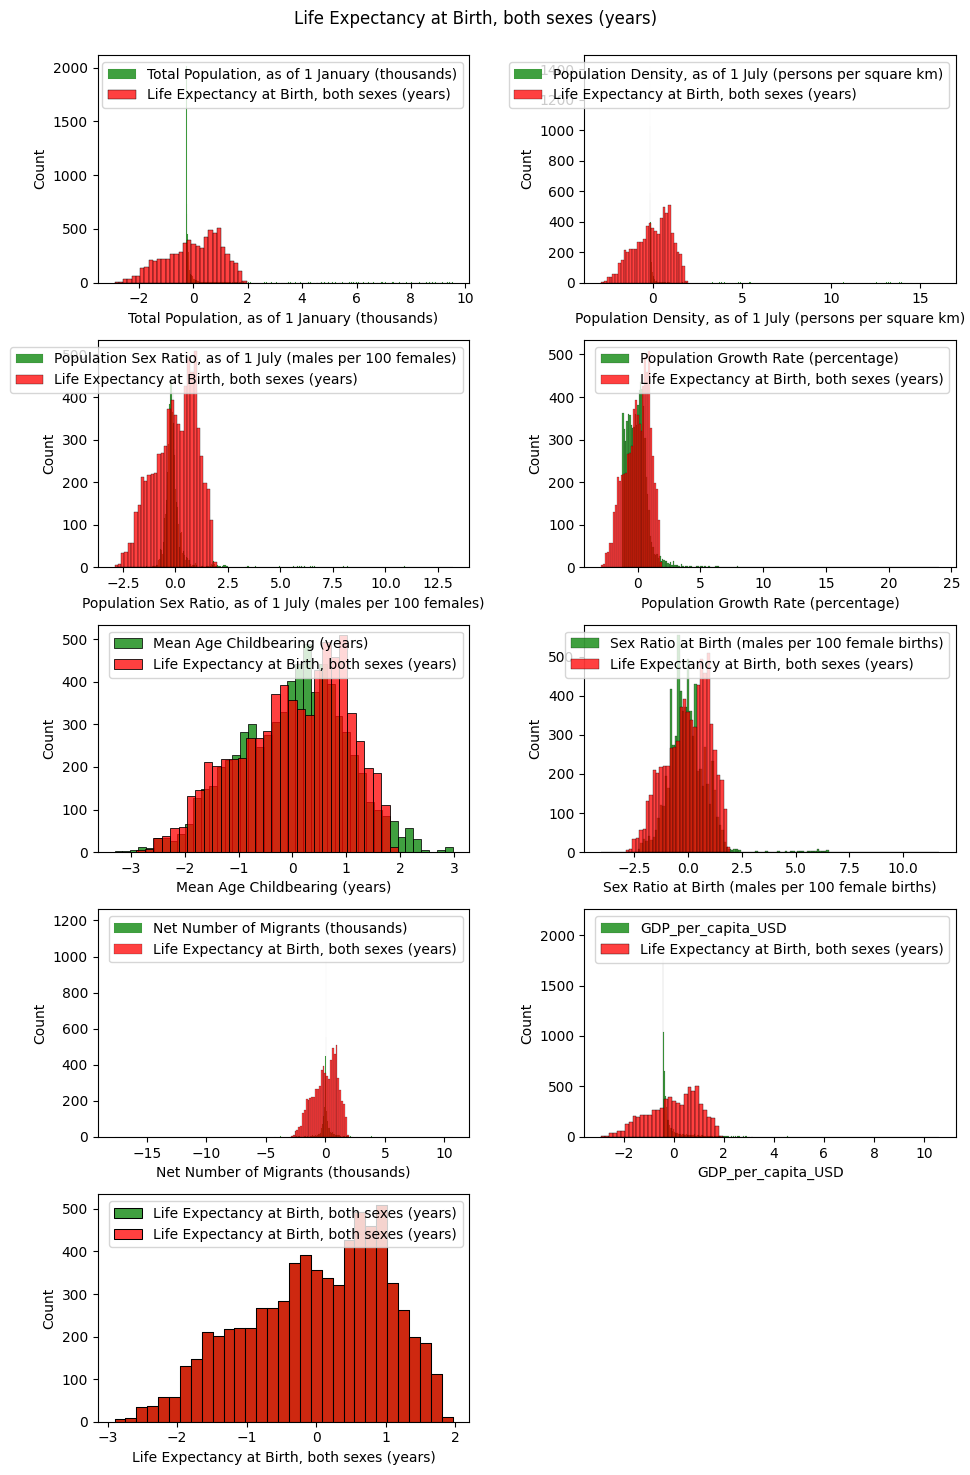

In [32]:
fig = plt.figure(figsize = (10, 15))
j = 0
for i in df_train_scaled.columns:
    plt.subplot(5,2, j+1) # for 10 features split to tow row
    j += 1
    sns.histplot(df_train_scaled.loc[:,i], color='g', label = i)
    sns.histplot(df_train_scaled[target], color='r', label = target)
    plt.legend(loc='best')
fig.suptitle(target)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [33]:
df_train_scaled.columns

Index(['Total Population, as of 1 January (thousands)',
       'Population Density, as of 1 July (persons per square km)',
       'Population Sex Ratio, as of 1 July (males per 100 females)',
       'Population Growth Rate (percentage)', 'Mean Age Childbearing (years)',
       'Sex Ratio at Birth (males per 100 female births)',
       'Net Number of Migrants (thousands)', 'GDP_per_capita_USD',
       'Life Expectancy at Birth, both sexes (years)'],
      dtype='object')

## Split data to train and test part

In [34]:
from sklearn.model_selection import train_test_split
X = df_train_scaled.drop('Life Expectancy at Birth, both sexes (years)', axis=1)
Y = df_train_scaled['Life Expectancy at Birth, both sexes (years)']
# Split the data 
train_data, test_data, train_target, test_target = train_test_split(X,Y , test_size=0.2, random_state=54)

## Train the Model with Random Forest Regressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(train_data, train_target)


RandomForestRegressor(random_state=0)

## Evaluation Random Forest Regressor model

In [36]:

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
predictions = model.predict(test_data)
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("r2_score:" ,r2_score(test_target, predictions))

Mean Absolute Error: 0.09399605461409685
Mean Squared Error: 0.02505989996883197
r2_score: 0.9745746403435627


## Cross validation score

In [37]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_data, train_target, cv=5, scoring='r2')
print("R2_scores=",scores)

R2_score= [0.97454706 0.96938872 0.97102376 0.97415307 0.96329379]


## Train the model with Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data, train_target)


LinearRegression()

## Evaluation Linear Regression model

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
predictions = model.predict(test_data)
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("r2_score:" ,r2_score(test_target, predictions))

Mean Absolute Error: 0.5680519270712936
Mean Squared Error: 0.557551099660925
r2_score: 0.4343178842153266


## Cross validation score

In [40]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, train_data, train_target, cv=5, scoring='r2')
print("R2_score=",scores)

R2_score= [0.47652036 0.47552853 0.41671809 0.47049253 0.48564014]


## Using AutoMl Method

In [48]:
import re
# AutoML do not support special JSON characters in feature name.
train_data = train_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_data  = test_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [46]:
from flaml import AutoML
automl = AutoML(task='regression', time_budget=120,verbose=False)
automl.fit(train_data,train_target)

In [49]:
predictions = automl.predict(test_data)
mae = mean_absolute_error(test_target, predictions)
mse = mean_squared_error(test_target, predictions)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("r2_score:" ,r2_score(test_target, predictions))

Mean Absolute Error: 0.071822074603049
Mean Squared Error: 0.013935352313511272
r2_score: 0.9858614222342922
